In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
torch.manual_seed(0)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler

class BernoulliSampler(Sampler):
    def __init__(self, data_source, p=0.5):
        """ 伯努利采样器初始化
        参数:
        data_source (Dataset): 数据集，用于确定采样总数
        p (float): 每个样本被选中的概率
        """
        self.data_source = data_source
        self.p = p

    def __iter__(self):
        n = len(self.data_source)
        # 生成随机决定，1 表示选择该索引，0 表示不选择
        selection = torch.bernoulli(torch.full((n,), self.p))
        # 选择被选中的索引
        return iter([i for i, flag in enumerate(selection) if flag == 1])

    def __len__(self):
        # 期望长度是总长度乘以选择概率 p
        return int(len(self.data_source) * self.p)

Files already downloaded and verified
Files already downloaded and verified
 frog truck truck  deer


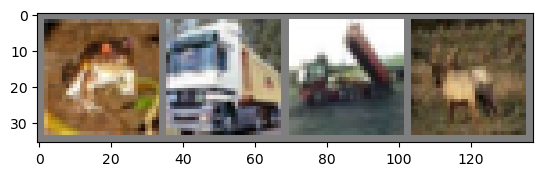

In [3]:
transform = transforms.Compose(
	[transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
										download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
											sampler=BernoulliSampler(trainset, p=0.8), num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
										download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
										shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
			'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [4]:
print("原始数据集的长度：", len(trainset))

print(len(trainloader))

原始数据集的长度： 50000
10000


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        Function to predict data's classification
        args : neural net, data
        output : prediction
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def partial_grad(self, data, target, loss_function):
        """
        Function to compute the grad
        args : data, target, loss_function
        return loss
        """
        outputs = self.forward(data)
        loss = loss_function(outputs, target)
        loss.backward() #compute grad
        return loss
    
    def calculate_loss_grad(self, dataset, loss_function, n_samples):
        """
        Function to compute the full loss and the full gradient
        args : dataset, loss function and number of samples
        return : total loss and full grad norm
        """
        total_loss = 0.0
        full_grad = 0.0
        for i_grad, data_grad in enumerate(dataset):
            inputs, labels = data_grad
            inputs, labels = Variable(inputs), Variable(labels) #wrap data and target into variable
            total_loss += (1./n_samples) * self.partial_grad(inputs, labels, loss_function).item()
        
        for para in self.parameters():
            full_grad += para.grad.data.norm(2)**2
        
        return total_loss, (1./n_samples) * np.sqrt(full_grad)
    
    def svrg_backward(self, dataset, loss_function, n_epoch, learning_rate):
        """
        Function to updated weights with a SVRG backpropagation
        args : dataset, loss function, number of epochs, learning rate
        return : total_loss_epoch, grad_norm_epoch
        """
        total_loss_epoch = [0 for i in range(n_epoch)]
        grad_norm_epoch = [0 for i in range(n_epoch)]
        for epoch in range(n_epoch):
            running_loss = 0.0
            previous_net_sgd = copy.deepcopy(self) #update previous_net_sgd
            previous_net_grad = copy.deepcopy(self) #update previous_net_grad

            #Compute full grad
            previous_net_grad.zero_grad() # grad = 0
            total_loss_epoch[epoch], grad_norm_epoch[epoch] = previous_net_grad.calculate_loss_grad(dataset, loss_function, n_samples)
            print(total_loss_epoch[epoch], grad_norm_epoch[epoch])
            #Run over the dataset
            for i_data, data in enumerate(dataset):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels) #wrap data and target into variable
                
                #Compute prev stoc grad
                previous_net_sgd.zero_grad() #grad = 0
                prev_loss = previous_net_sgd.partial_grad(inputs, labels, loss_function)
                
                #Compute cur stoc grad
                self.zero_grad() #grad = 0
                cur_loss = self.partial_grad(inputs, labels, loss_function)
                
                #Backward
                for param1, param2, param3 in zip(self.parameters(), previous_net_sgd.parameters(), previous_net_grad.parameters()): 
                    param1.data -= (learning_rate) * (param1.grad.data - param2.grad.data + (1./n_samples) * param3.grad.data)

                # print statistics
                running_loss += cur_loss.item()
                if i_data % 2500 == 2499:    # print every 2500 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i_data + 1, running_loss / 2500))
                    running_loss = 0.0
                
        return total_loss_epoch, grad_norm_epoch

In [6]:
net = Net()
criterion = nn.CrossEntropyLoss()
n_epoch = 100
learning_rate = 0.01
start = time.time()
n_samples = len(trainloader)
print(n_samples)
total_loss_epoch, grad_norm_epoch = net.svrg_backward(trainloader, criterion, n_epoch, learning_rate)

end = time.time()
print('time is : ', end - start)
print('Finished Training')

10000
2.2980977710485506 tensor(0.0419)
[1,  2500] loss: 2.193
[1,  5000] loss: 1.835
[1,  7500] loss: 1.649
1.5261379191026059 tensor(1.6114)
[2,  2500] loss: 1.378
[2,  5000] loss: 1.352
[2,  7500] loss: 1.327
1.2831425594892376 tensor(1.5827)
[3,  2500] loss: 1.195
[3,  5000] loss: 1.180
[3,  7500] loss: 1.196
1.2146569443915032 tensor(1.8339)
[4,  2500] loss: 1.130
[4,  5000] loss: 1.148
[4,  7500] loss: 1.148
1.1085445954747488 tensor(0.9683)
[5,  2500] loss: 1.052
[5,  5000] loss: 1.018
[5,  7500] loss: 1.045
[5, 10000] loss: 0.987
0.9834104262036747 tensor(1.1364)
[6,  2500] loss: 0.966
[6,  5000] loss: 0.950
[6,  7500] loss: 0.972
0.9447773040385925 tensor(1.0153)
[7,  2500] loss: 0.920
[7,  5000] loss: 0.925
[7,  7500] loss: 0.931
[7, 10000] loss: 0.882
0.8741548039719449 tensor(0.5546)
[8,  2500] loss: 0.857
[8,  5000] loss: 0.859
[8,  7500] loss: 0.872
[8, 10000] loss: 0.842
0.8091574716418991 tensor(0.5629)
[9,  2500] loss: 0.812
[9,  5000] loss: 0.825
[9,  7500] loss: 0.81

[71,  7500] loss: 0.843
0.7324953663591995 tensor(0.5771)
[72,  2500] loss: 0.702
[72,  5000] loss: 0.698
[72,  7500] loss: 0.754
[72, 10000] loss: 0.729
0.8432886765631892 tensor(1.1789)
[73,  2500] loss: 0.835
[73,  5000] loss: 0.904
[73,  7500] loss: 0.920
0.8593093927318148 tensor(0.9694)
[74,  2500] loss: 0.824
[74,  5000] loss: 0.819
[74,  7500] loss: 0.829
[74, 10000] loss: 0.847
0.9042512177762304 tensor(1.1892)
[75,  2500] loss: 0.784
[75,  5000] loss: 0.826
[75,  7500] loss: 0.814
[75, 10000] loss: 0.844
0.8831678372647168 tensor(1.1517)
[76,  2500] loss: 0.873
[76,  5000] loss: 0.940
[76,  7500] loss: 0.945
0.9379944546057484 tensor(0.9482)
[77,  2500] loss: 0.852
[77,  5000] loss: 0.857
[77,  7500] loss: 0.873
[77, 10000] loss: 0.841
0.8222028290958695 tensor(0.7562)
[78,  2500] loss: 0.736
[78,  5000] loss: 0.801
[78,  7500] loss: 0.825
[78, 10000] loss: 0.842
0.8811039096436611 tensor(1.3430)
[79,  2500] loss: 0.842
[79,  5000] loss: 0.840
[79,  7500] loss: 0.863
[79, 100

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car truck   cat
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 60 %
Accuracy of   car : 74 %
Accuracy of  bird : 45 %
Accuracy of   cat : 61 %
Accuracy of  deer : 50 %
Accuracy of   dog : 28 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 74 %
Accuracy of truck : 55 %


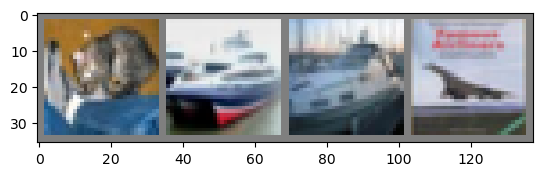

In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

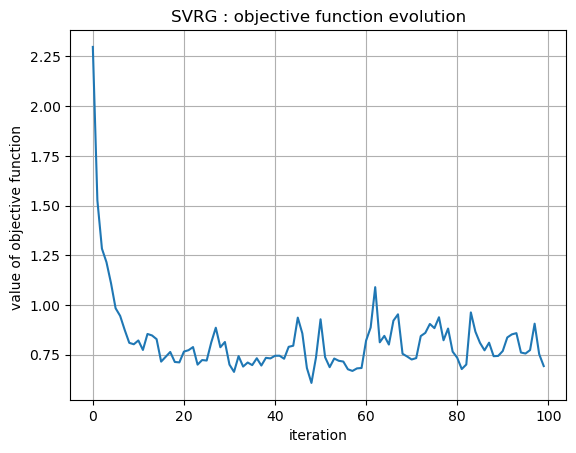

No handles with labels found to put in legend.


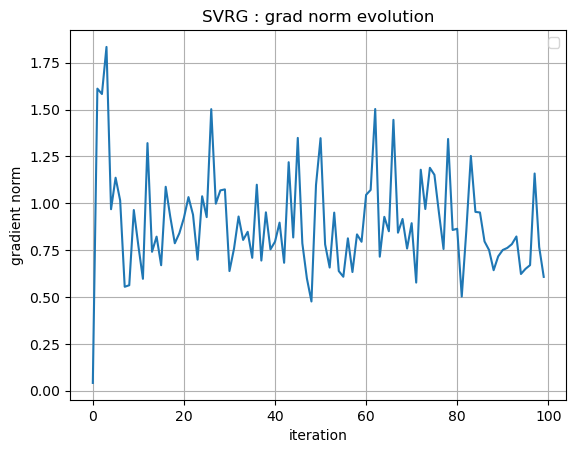

In [8]:
epoch_abs = [i for i in range(n_epoch)]
plt.plot(epoch_abs, total_loss_epoch)
plt.xlabel('iteration')
plt.ylabel('value of objective function ')
plt.title('SVRG : objective function evolution')
plt.grid()
plt.show()

plt.plot(epoch_abs, grad_norm_epoch)
plt.xlabel('iteration')
plt.ylabel('gradient norm')
plt.title('SVRG : grad norm evolution')
plt.grid()
plt.legend(loc=1)
plt.show()